# **Exercise 11.3 Generate Images with DCGAN**


In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


## **Import needed libraries**

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
from skimage.io import imread

In [3]:
def time_string(sec_elapsed):
    hour = int(sec_elapsed / (60 * 60))
    minute = int((sec_elapsed % (60 * 60)) / 60)
    second = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(hour, minute, second)

## **Resolution, channels, preview rows and columns, SEED, DATA PATH, EPOCH, BATCH SIZE, BUFFER SIZE**

In [10]:
gen_res = 3
img_chan = 3
gen_square = 32 * gen_res
img_rows = 5
img_cols = 5
img_margin = 16
seed_vector = 200
data_path = 'apple-or-tomato/training_set/'
epochs = 1000
num_batch = 32
num_buffer = 60000

print(f"Will generate a resolution of {gen_res}.")
print(f"Will generate {gen_square}px square images.")
print(f"Will generate {img_chan} image channels.")
print(f"Will generate {img_rows} preview rows.")
print(f"Will generate {img_cols} preview columns.")
print(f"Our preview margin equals {img_margin}.")
print(f"Our data path is: {data_path}.")
print(f"Our number of epochs are: {epochs}.")
print(f"Will generate a batch size of {num_batch}.")
print(f"Will generate a buffer size of {num_buffer}.")

Will generate a resolution of 3.
Will generate 96px square images.
Will generate 3 image channels.
Will generate 5 preview rows.
Will generate 5 preview columns.
Our preview margin equals 16.
Our data path is: apple-or-tomato/training_set/.
Our number of epochs are: 1000.
Will generate a batch size of 32.
Will generate a buffer size of 60000.


In [12]:
training_binary_path = os.path.join(data_path,
        f'training_data_{gen_square}_{gen_square}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
    start = time.time()
    print("Loading images...")

    train_data = []
    images_path = os.path.join(data_path,'tomato')
    for filename in tqdm(os.listdir(images_path)):
        path = os.path.join(images_path,filename)
        images = Image.open(path).resize((gen_square,
            gen_square),Image.ANTIALIAS)
        train_data.append(np.asarray(images))
    train_data = np.reshape(train_data,(-1,gen_square,
            gen_square,img_chan))
    train_data = train_data.astype(np.float32)
    train_data = train_data / 127.5 - 1.


    print("Saving training images...")
    np.save(training_binary_path,train_data)
    elapsed = time.time()-start
    print (f'Image preprocessing time: {time_string(elapsed)}')
else:
    print("Loading the training data...")
    train_data = np.load(training_binary_path)

Looking for file: apple-or-tomato/training_set/training_data_96_96.npy
Loading the training data...


In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_data) \
    .shuffle(num_buffer).batch(num_batch)

2021-10-29 18:03:26.737266: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **Build the Generator and Discrminator**

In [14]:
def create_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if gen_res>1:
        model.add(UpSampling2D(size=(gen_res,gen_res)))
        model.add(Conv2D(128,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def create_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [15]:
def save_images(cnt,noise):
    img_array = np.full(( 
        img_margin + (img_rows * (gen_square+img_margin)), 
        img_margin + (img_cols * (gen_square+img_margin)), 3), 
        255, dtype=np.uint8)
  
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    img_count = 0
    for row in range(img_rows):
        for col in range(img_cols):
            r = row * (gen_square+16) + img_margin
            c = col * (gen_square+16) + img_margin
            img_array[r:r+gen_square,c:c+gen_square] \
                = gen_imgs[img_count] * 255
            img_count += 1

          
    output_path = os.path.join(data_path,'output')
    if not os.path.exists(output_path):
        os.makedirs(output_path)
  
    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(img_array)
    im.save(filename)

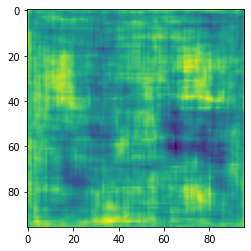

In [16]:
generator = create_generator(seed_vector, img_chan)

noise = tf.random.normal([1, seed_vector])
gen_img = generator(noise, training=False)

plt.imshow(gen_img[0, :, :, 0])

In [17]:
img_shape = (gen_square,gen_square,img_chan)

discriminator = create_discriminator(img_shape)
decision = discriminator(gen_img)
print (decision)

tf.Tensor([[0.5005962]], shape=(1, 1), dtype=float32)


In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discrim_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def gen_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
gen_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
disc_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [20]:
@tf.function
def train_step(images):
    seed = tf.random.normal([num_batch, seed_vector])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_imgs = generator(seed, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(gen_imgs, training=True)

        g_loss = gen_loss(fake_output)
        d_loss = discrim_loss(real_output, fake_output)


        gradients_of_generator = gen_tape.gradient(\
            g_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(\
            d_loss, discriminator.trainable_variables)

        gen_optimizer.apply_gradients(zip(
            gradients_of_generator, generator.trainable_variables))
        disc_optimizer.apply_gradients(zip(
            gradients_of_discriminator, 
            discriminator.trainable_variables))
    return g_loss,d_loss

In [22]:
def train(dataset, epochs):
    fixed_seed = np.random.normal(0, 1, (img_rows * img_cols, 
                                       seed_vector))
    start = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        g_loss_list = []
        d_loss_list = []

        for image_batch in dataset:
            t = train_step(image_batch)
            g_loss_list.append(t[0])
            d_loss_list.append(t[1])

        generator_loss = sum(g_loss_list) / len(g_loss_list)
        discriminator_loss = sum(d_loss_list) / len(d_loss_list)

        epoch_elapsed = time.time()-epoch_start
        print (f'Epoch {epoch+1}, gen loss={generator_loss},disc loss={discriminator_loss},'\
           f' {time_string(epoch_elapsed)}')
        save_images(epoch,fixed_seed)

    elapsed = time.time()-start
    print (f'Training time: {time_string(elapsed)}')


In [23]:
train(train_dataset, epochs)

2021-10-29 18:05:40.694551: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1, gen loss=2.6256332397460938,disc loss=0.44953447580337524, 0:01:11.57
Epoch 2, gen loss=3.0611958503723145,disc loss=0.5719443559646606, 0:01:02.51
Epoch 3, gen loss=3.2427496910095215,disc loss=0.6098432540893555, 0:00:52.03
Epoch 4, gen loss=2.688871145248413,disc loss=1.0773324966430664, 0:00:55.30
Epoch 5, gen loss=2.158496618270874,disc loss=1.3300279378890991, 0:01:02.03
Epoch 6, gen loss=2.2589030265808105,disc loss=1.1785333156585693, 0:00:52.75
Epoch 7, gen loss=2.331599712371826,disc loss=1.199823021888733, 0:00:59.40
Epoch 8, gen loss=2.2243056297302246,disc loss=1.176113486289978, 0:00:56.94
Epoch 9, gen loss=2.140230178833008,disc loss=1.3953707218170166, 0:00:57.23
Epoch 10, gen loss=2.0387909412384033,disc loss=1.342348575592041, 0:00:57.40
Epoch 11, gen loss=2.004645824432373,disc loss=1.1653015613555908, 0:00:59.84
Epoch 12, gen loss=2.2482171058654785,disc loss=1.3021776676177979, 0:01:00.65
Epoch 13, gen loss=2.155640125274658,disc loss=1.3053537607192993, 0

Epoch 106, gen loss=2.19590425491333,disc loss=0.9053924679756165, 0:00:55.41
Epoch 107, gen loss=2.1785173416137695,disc loss=1.0034453868865967, 0:00:56.58
Epoch 108, gen loss=2.226116180419922,disc loss=1.0711065530776978, 0:00:51.90
Epoch 109, gen loss=2.2106781005859375,disc loss=0.8647938966751099, 0:00:57.60
Epoch 110, gen loss=2.0947070121765137,disc loss=1.082727074623108, 0:01:01.19
Epoch 111, gen loss=2.139833688735962,disc loss=0.8902962803840637, 0:00:56.66
Epoch 112, gen loss=2.0755295753479004,disc loss=0.9996516108512878, 0:00:56.81
Epoch 113, gen loss=2.14810848236084,disc loss=0.8374868631362915, 0:00:50.53
Epoch 114, gen loss=2.1871771812438965,disc loss=0.9032682180404663, 0:00:52.00
Epoch 115, gen loss=2.1889424324035645,disc loss=1.0803463459014893, 0:00:52.84
Epoch 116, gen loss=2.369636058807373,disc loss=0.9531511068344116, 0:00:52.90
Epoch 117, gen loss=2.261662721633911,disc loss=0.9877794981002808, 0:00:54.50
Epoch 118, gen loss=2.3549928665161133,disc loss=

Epoch 210, gen loss=2.6706597805023193,disc loss=0.923319935798645, 0:00:52.84
Epoch 211, gen loss=2.3358395099639893,disc loss=1.0230716466903687, 0:00:50.31
Epoch 212, gen loss=2.4225401878356934,disc loss=1.0095107555389404, 0:00:53.41
Epoch 213, gen loss=2.469996690750122,disc loss=1.0419843196868896, 0:00:49.83
Epoch 214, gen loss=2.4116132259368896,disc loss=0.8850711584091187, 0:00:50.20
Epoch 215, gen loss=2.6612708568573,disc loss=1.005568027496338, 0:00:49.40
Epoch 216, gen loss=2.6408255100250244,disc loss=0.7712061405181885, 0:00:50.10
Epoch 217, gen loss=2.457331657409668,disc loss=0.8592573404312134, 0:00:49.78
Epoch 218, gen loss=2.533677101135254,disc loss=0.8127163052558899, 0:00:50.13
Epoch 219, gen loss=2.527409076690674,disc loss=0.966823935508728, 0:00:50.07
Epoch 220, gen loss=2.3810834884643555,disc loss=0.8574753999710083, 0:00:53.25
Epoch 221, gen loss=2.5821380615234375,disc loss=1.1025850772857666, 0:00:55.18
Epoch 222, gen loss=2.4793152809143066,disc loss=0

Epoch 314, gen loss=2.8738484382629395,disc loss=0.8888185620307922, 0:00:50.76
Epoch 315, gen loss=2.7483928203582764,disc loss=0.7208241820335388, 0:00:52.31
Epoch 316, gen loss=2.95167875289917,disc loss=0.6437655687332153, 0:00:50.54
Epoch 317, gen loss=3.1297926902770996,disc loss=0.6452878713607788, 0:00:54.06
Epoch 318, gen loss=2.732917547225952,disc loss=0.6988762617111206, 0:00:51.64
Epoch 319, gen loss=3.0497562885284424,disc loss=0.6390584707260132, 0:00:50.41
Epoch 320, gen loss=3.2801735401153564,disc loss=0.7483845353126526, 0:00:51.99
Epoch 321, gen loss=3.3817379474639893,disc loss=1.0336346626281738, 0:00:51.56
Epoch 322, gen loss=2.784355401992798,disc loss=0.7762819528579712, 0:00:53.18
Epoch 323, gen loss=2.9524660110473633,disc loss=0.6087585687637329, 0:00:52.95
Epoch 324, gen loss=2.976992130279541,disc loss=0.6839288473129272, 0:00:53.53
Epoch 325, gen loss=3.024024486541748,disc loss=0.66535484790802, 0:00:50.23
Epoch 326, gen loss=3.1235427856445312,disc loss

KeyboardInterrupt: 

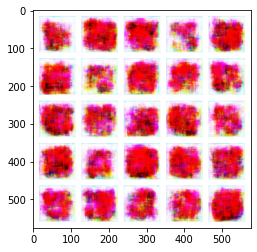

In [ ]:
a = imread('/content/drive/MyDrive/Datasets/apple-or-tomato/training_set/output/train-0.png')
plt.imshow(a)

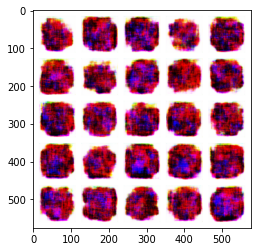

In [ ]:
a = imread('/content/drive/MyDrive/Datasets/apple-or-tomato/training_set/output/train-1.png')
plt.imshow(a)

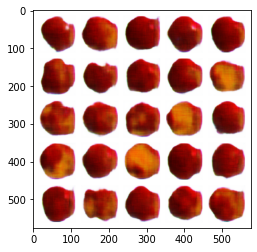

In [ ]:
a = imread('/content/drive/MyDrive/Datasets/apple-or-tomato/training_set/output/train-25.png')
plt.imshow(a)

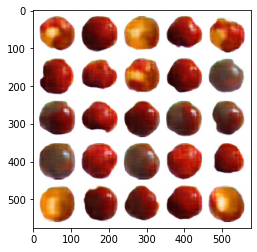

In [ ]:
a = imread('/content/drive/MyDrive/Datasets/apple-or-tomato/training_set/output/train-50.png')
plt.imshow(a)

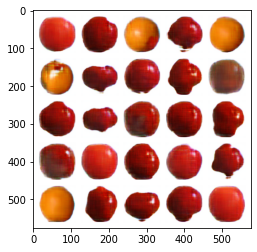

In [ ]:
a = imread('/content/drive/MyDrive/Datasets/apple-or-tomato/training_set/output/train-100.png')
plt.imshow(a)

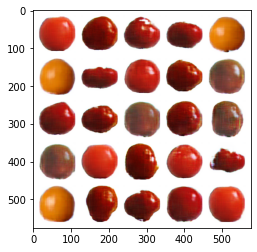

In [ ]:
a = imread('/content/drive/MyDrive/Datasets/apple-or-tomato/training_set/output/train-250.png')
plt.imshow(a)

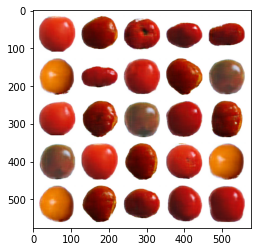

In [ ]:
a = imread('/content/drive/MyDrive/Datasets/apple-or-tomato/training_set/output/train-500.png')
plt.imshow(a)

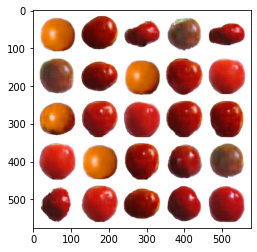

In [ ]:
a = imread('/content/drive/MyDrive/Datasets/apple-or-tomato/training_set/output/train-750.png')
plt.imshow(a)

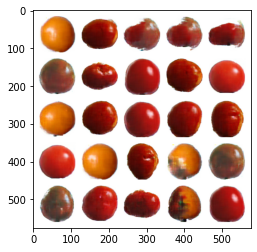

In [ ]:
a = imread('/content/drive/MyDrive/Datasets/apple-or-tomato/training_set/output/train-999.png')
plt.imshow(a)

In [ ]:
# generator.save(os.path.join(DATA_PATH,"tomato_generator.h5"))